In [1]:
from lib import cnn_tester
import sys
sys.path.insert(0, '../src')
from lib import datasets

from os.path import join as opj
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Hyperparameters validation - Computation of performance

In [2]:
# Directories
data_dir = '../data/preprocessed/BrainPedia_dataset'
out_dir = '../data/derived/BrainPedia_dataset'

In [3]:
# Specific setup
preprocess_type = 'resampled_masked_normalized'

# Training setup 
train_subset ='bp_dataset'
lr_to_test = ['1e-04', '1e-05']
model_to_test = ['model_cnn_4layers', 'model_cnn_5layers']
init_to_test = ['retrain_no', 'retrain_all']
batch_to_test = [32, 64]
epochs_to_test = [500, 1000]

# Validation setup
valid_id_file = opj(data_dir, f'test_{train_subset}.txt')
label_file = opj(data_dir, f'{train_subset}_labels.csv')
label_col = 'tags'
label_filelist = pd.read_csv(opj(data_dir, 
                                 f'{train_subset}_labels.csv'))

label_list = sorted(np.unique(label_filelist[label_col]))

valid_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), valid_id_file, label_file, label_col,
                                  label_list)

In [4]:
accuracies = []
f1_list = []
model_list = []
arch_list = []
epochs_list = []
batch_list = []
lr_list = []
prec_list = []
rec_list = []

if not os.path.exists('../figures/validation_model_bp.csv'):
    print('Calculating validation performance...')
    for model in model_to_test:
        for init in init_to_test:
            for epochs in epochs_to_test:
                for batch in batch_to_test:
                    for lr in lr_to_test:
                        model_list.append(init)
                        arch_list.append(model)
                        batch_list.append(batch)
                        epochs_list.append(epochs)
                        lr_list.append(lr)

                        # Model to test
                        parameter_file = opj(out_dir, f"{train_subset}_maps_classification_tags_{model}_" + \
                                f"{init}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}", 
                                             "model_final.pt")

                        acc, f1, prec, rec, acc_class = cnn_tester.tester(valid_set, 
                                                                          parameter_file) # Compute results

                        accuracies.append(acc)
                        f1_list.append(f1)
                        prec_list.append(prec)
                        rec_list.append(rec)
                    
    # Creation of dataframe with results
    init_list = ['Default algorithm' if i == 'retrain_no' else 'Pre-trained CAE' for i in model_list]

    arch_list = ['5 layers' if i == 'model_cnn_5layers' else '4 layers' for i in arch_list]

    df = pd.DataFrame()
    df['Accuracy']=accuracies
    df['F1']=f1_list
    df['Initialization']=init_list
    df['Batch']=batch_list
    df['Epochs']=epochs_list
    df['Architecture']=arch_list
    df['Precision']=prec_list
    df['Recall']=rec_list
    
    df.to_csv('../figures/validation_model_bp.csv') 

else:
    print('Performance already computed.')

Performance already computed.


# Hyperparameter validation - Exploration of results

### Table 3 - Hyperparameters chosen for each dataset and corresponding performance of the classifier on the validation set of the dataset 

Here, we computed the results of Table 3 for BrainPedia dataset.

In [5]:
df = pd.read_csv('../figures/validation_model_bp.csv') 
df[df['Initialization']=='Default algorithm'].nlargest(1, ['Accuracy', 'F1'])

,Unnamed: 0,Accuracy,F1,Model,Batch,Epochs,Learning rate,Initialization
3,3,0.791216,0.7805,4 layers,64,500,0.00001,Default algorithm


In [6]:
df[df['Initialization']=='Pre-trained CAE'].nlargest(1, ['Accuracy', 'F1'])

,Unnamed: 0,Accuracy,F1,Model,Batch,Epochs,Learning rate,Initialization
25,25,0.804583,0.793511,5 layers,32,500,0.00001,Pre-trained CAE


# Test models with cross-validation

## Small BrainPedia

In [7]:
if not os.path.exists('../figures/comparison_small_bp.csv'):
    accuracies = []
    f1_list = []
    model_list = []

    sets = 'small_bp_dataset'
    train_id_file = opj(data_dir, f'train_{sets}.txt')
    test_id_file = opj(data_dir, f'valid_{sets}.txt')
    label_file = opj(data_dir, f'{sets}_labels.csv')
    label_col = 'tags'
    label_filelist = pd.read_csv(opj('../data/preprocessed/BrainPedia_dataset', 
                                     f'small_bp_dataset_labels.csv'))
    label_list = sorted(np.unique(label_filelist['tags']))
    train_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), train_id_file, label_file, label_col, 
                                       label_list)
    test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col, 
                                      label_list)

    lr = '1e-04'
    device='cpu'

    model = 'model_cnn_4layers_retrain_no'
    epochs = 500
    batch=64
    lr = '1e-05'
    model_list.append('Default algorithm')
    parameter_file = opj(out_dir, 
     f'{sets}_maps_classification_tags_{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                 f'model_final.pt')

    acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

    accuracies.append(acc)
    f1_list.append(f1)

    model = 'model_cnn_5layers_retrain_all'
    epochs = 500
    batch=32
    lr = '1e-05'
    model_list.append('Pre-trained CAE')
    parameter_file = opj(out_dir, 
     f'{sets}_maps_classification_tags_{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                 f'model_final.pt')


    acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

    accuracies.append(acc)
    f1_list.append(f1)


    df_sbp = pd.DataFrame()
    df_sbp['Accuracy']=accuracies
    df_sbp['F1']=f1_list
    df_sbp['Model']=model_list

    df_sbp.to_csv('../figures/comparison_small_bp.csv')
    
else:
    print('Performance already computed.')
    df_sbp = pd.read_csv('../figures/comparison_small_bp.csv')

Performance already computed.


In [8]:
print('Accuracy')
print('Default algorithm')
print(str(round(np.mean(df_sbp['Accuracy'][df_sbp['Model']=='Default algorithm']) * 100, 1)))

print('Pre-trained CAE')
print(str(round(np.mean(df_sbp['Accuracy'][df_sbp['Model']=='Pre-trained CAE']) * 100, 1)))

Accuracy
Default algorithm
72.1
Pre-trained CAE
72.6


In [9]:
print('F1-score')
print('Default algorithm')
print(str(round(np.mean(df_sbp['F1'][df_sbp['Model']=='Default algorithm']) * 100, 1)))

print('Pre-trained CAE')
print(str(round(np.mean(df_sbp['F1'][df_sbp['Model']=='Pre-trained CAE']) * 100, 1)))

F1-score
Default algorithm
66.0
Pre-trained CAE
72.1


## Large BrainPedia

In [10]:
if not os.path.exists('../figures/comparison_bp.csv'):
    accuracies = []
    f1_list = []
    model_list = []

    sets = 'bp_dataset'
    train_id_file = opj(data_dir, f'train_{sets}.txt')
    test_id_file = opj(data_dir, f'valid_{sets}.txt')
    label_file = opj(data_dir, f'{sets}_labels.csv')
    label_col = 'tags'
    label_filelist = pd.read_csv(opj('../data/preprocessed/BrainPedia_dataset', 
                                     f'bp_dataset_labels.csv'))
    label_list = sorted(np.unique(label_filelist['tags']))
    train_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), train_id_file, label_file, label_col, 
                                       label_list)
    test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col, 
                                      label_list)

    lr = '1e-04'
    device='cpu'

    model = 'model_cnn_4layers_retrain_no'
    epochs = 500
    batch=64
    lr = '1e-05'
    model_list.append('Default algorithm')
    parameter_file = opj(out_dir, 
     f'{sets}_maps_classification_tags_{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                 f'model_final.pt')

    acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

    accuracies.append(acc)
    f1_list.append(f1)

    model = 'model_cnn_5layers_retrain_all'
    epochs = 500
    batch=32
    lr = '1e-05'
    model_list.append('Pre-trained CAE')
    parameter_file = opj(out_dir, 
     f'{sets}_maps_classification_tags_{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                 f'model_final.pt')


    acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

    accuracies.append(acc)
    f1_list.append(f1)


    df_bp = pd.DataFrame()
    df_bp['Accuracy']=accuracies
    df_bp['F1']=f1_list
    df_bp['Model']=model_list

    df_bp.to_csv('../figures/comparison_bp.csv')
    
else:
    print('Performance already computed.')
    df_bp = pd.read_csv('../figures/comparison_bp.csv')

Performance already computed.


In [11]:
print('Accuracy')
print('Default algorithm')
print(str(round(np.mean(df_bp['Accuracy'][df_bp['Model']=='Default algorithm']) * 100, 1)))

print('Pre-trained CAE')
print(str(round(np.mean(df_bp['Accuracy'][df_bp['Model']=='Pre-trained CAE']) * 100, 1)))

Accuracy
Default algorithm
79.8
Pre-trained CAE
81.2


In [12]:
print('F1-score')
print('Default algorithm')
print(str(round(np.mean(df_bp['F1'][df_bp['Model']=='Default algorithm']) * 100, 1)))

print('Pre-trained CAE')
print(str(round(np.mean(df_bp['F1'][df_bp['Model']=='Pre-trained CAE']) * 100, 1)))

F1-score
Default algorithm
76.6
Pre-trained CAE
79.8


In [13]:
df_sbp = pd.read_csv('../figures/comparison_small_bp.csv')
df_bp = pd.read_csv('../figures/comparison_bp.csv')

df_sbp['Dataset'] = 'Small'
df_bp['Dataset']='Large'

df = df_sbp.append(df_bp)

/Users/egermani/miniforge3/envs/workEnv/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/egermani/miniforge3/envs/workEnv/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.8666666666666667, 0.5176470588235295, 0.3215686274509804)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


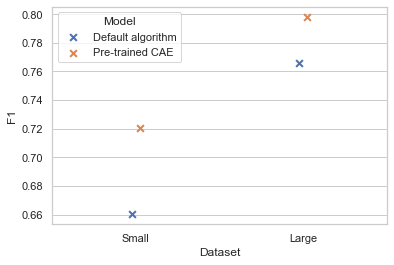

In [14]:
# Figure 7
sns.set_theme(style="whitegrid")
ax = sns.pointplot(x="Dataset", y="F1", hue='Model',
                 data=df, dodge=True, size=20, join = False, markers = 'x')

ax.figure.savefig('../figures/fig7.png')